SELECTIVE SAPCE PCE

In [15]:
import itertools
import math
import numpy as np
import UQpy
from scipy.special import comb
from UQpy.distributions import Uniform,Normal, JointIndependent
from UQpy.surrogates.polynomial_chaos import TotalDegreeBasis, LeastSquareRegression
from UQpy.sensitivity import PceSensitivity
from UQpy.sampling import MonteCarloSampling
from sklearn.metrics import mean_squared_error, r2_score
import time  
import scipy as sp
import random
import matplotlib.pyplot as plt

import SAPCE

In [16]:
def root_mean_squared_error(y_true, y_pred, multioutput='uniform_average'):
    mse = mean_squared_error(y_true, y_pred, multioutput=multioutput)
    if isinstance(mse, np.ndarray):
        return np.sqrt(mse)
    return np.sqrt(mse)


In [17]:
import pandas as pd
data = pd.read_csv('Oakwood.csv', sep=';', header=0)
data_NVM= pd.read_csv('Oakwood_NVM.csv', sep=';', header=0)

names=data.columns.tolist()
data_array=data.to_numpy()

names_NVM=data_NVM.columns.tolist()
data_array_NVM=data_NVM.to_numpy()

In [18]:
X=data_array[:,:12]
Y_all=data_array[:,12:]
Y_tunnel=data_array[:,12:23]
Y_surface=data_array[:,23:]

Y_all_NVM=data_array_NVM[:,12:]

Y_N=Y_all_NVM[:,:113]
Y_V=Y_all_NVM[:,113:226]
Y_M=Y_all_NVM[:,226:]

In [19]:
Y_all.shape

(1000, 23)

In [20]:
# Concrete parameters
dist_Ec=Normal(13,1)
dist_Relax=Uniform(30,40)

# Soil1
dist_S1_Erel=Uniform(2,1)
dist_S1_E50=Normal(65,5)
dist_S1_c=Normal(30,5)
dist_S1_theta=Normal(30,1)
dist_S1_ko=Uniform(0.6,0.5)

# Soil2
dist_S1_Erel=Uniform(2,1)
dist_S1_E50=Normal(130,10)
dist_S1_c=Normal(5,1)
dist_S1_theta=Normal(42,1)
dist_S1_ko=Uniform(0.45,0.2)


marg = [dist_Ec,dist_Relax, dist_S1_Erel, dist_S1_E50, dist_S1_c,dist_S1_theta,dist_S1_ko,dist_S1_Erel,dist_S1_E50,dist_S1_c,dist_S1_theta,dist_S1_ko]
joint = JointIndependent(marginals=marg)

Enter 1 to show added design points during adaptation, otherwise press Enter:  


0
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 4366.020600552152
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 4366.020600552152
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1559.7324656633466
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1277.8572651806974
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1228.417203517211
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1227.9332704406945
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1103.8075543617008
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1118.7053376893177
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1081.3352256824573
Adaptive basis construction t

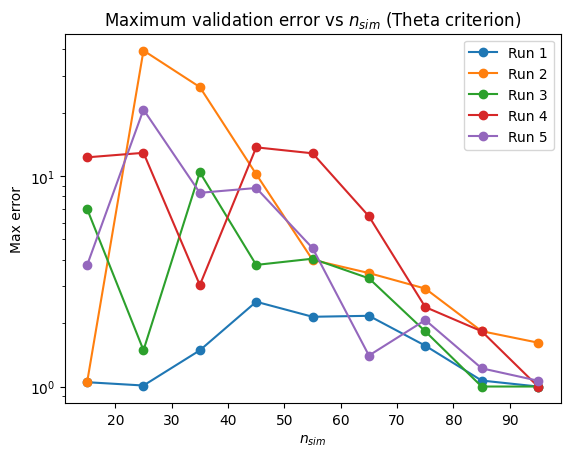

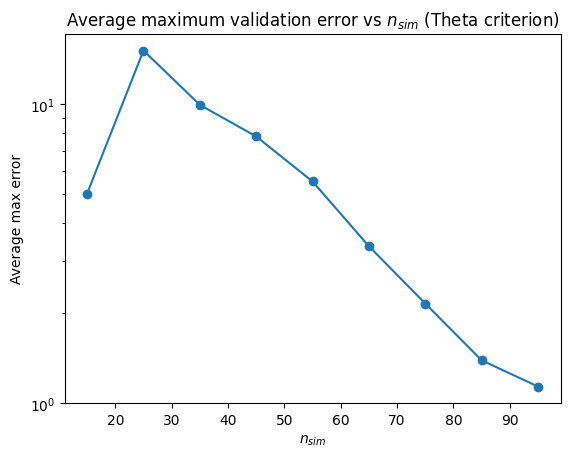

       y_true        y_pred
 0.000000e+00  0.000000e+00
 2.500000e-03  2.416622e-03
-3.142001e-03 -3.150291e-03
-8.818923e-03 -8.814132e-03
-3.730774e-03 -3.718683e-03
-5.975863e-03 -5.954957e-03
-2.951111e-03 -2.932120e-03
-8.701589e-03 -8.682303e-03
-6.160341e-03 -6.127012e-03
-4.750290e-04 -4.489385e-04
 1.293880e-04  1.556157e-04
 3.094550e-05  5.738037e-05
-1.127340e-04 -1.085519e-04
-3.065491e-03 -3.052132e-03
-1.010557e-02 -1.008825e-02
-1.601224e-02 -1.598597e-02
-2.366387e-02 -2.364499e-02
-2.776960e-02 -2.775282e-02
-2.439892e-02 -2.438276e-02
-1.771240e-02 -1.770480e-02
-1.135536e-02 -1.134554e-02
-3.574874e-03 -3.563314e-03
-3.019410e-04 -2.992993e-04
 0.000000e+00  0.000000e+00
 2.500000e-03  2.531837e-03
-4.041582e-03 -3.997804e-03
-1.032886e-02 -1.028085e-02
-6.064639e-03 -5.998997e-03
-8.294756e-03 -8.245529e-03
-4.313193e-03 -4.261452e-03
-1.022596e-02 -1.021056e-02
-7.086138e-03 -7.052253e-03
-1.149651e-03 -1.117207e-03
-5.752010e-04 -5.429308e-04
-1.204412e-03 -1.173

In [21]:
import numpy as np  # knihovna numpy
import matplotlib.pyplot as plt  # grafy plt
import random  # nahodne volby
from UQpy.sampling import ThetaCriterionPCE  # theta kriterium
import pandas as pd

show_design_plots = input("Enter 1 to show added design points during adaptation, otherwise press Enter: ").strip() == "1"  # volba vykresleni

errs_stat = []  # chyby behu
nsim_values = None

all_indices = np.arange(len(Y_all))  # vsechny indexy
base_n = 15
max_n = 100
increment = 10
n_steps = (max_n - base_n) // increment + 1  # pocet kroku
initial_indices_runs = [random.sample(list(all_indices), base_n) for _ in range(5)]  # start behu

for s in range(5):  # smycka behu
    print(s)
    errs = []
    nsim = []

    initial_indices = initial_indices_runs[s]  # pocatecni body
    remaining_indices = [idx for idx in all_indices if idx not in initial_indices]

    Xadapted = X[initial_indices, :]  # trenovaci X
    Yadapted = Y_all[initial_indices, :]  # trenovaci Y
    train_indices = list(initial_indices)

    for k in range(n_steps):  # smycka kroku
        n_new_this_step = 0

        if k > 0:
            for _ in range(increment):
                if not remaining_indices:
                    break
                if Xadapted.shape[0] >= max_n:
                    break

                sapce = SAPCE.SensitivityAdaptivePCE(  # vytvoreni sapce
                    pdf=joint,
                    exp_design_in=Xadapted,
                    exp_design_out=Yadapted,
                    max_partial_degree=10,
                    num_inputs=12,
                )
                sapce.construct_adaptive_basis(max_condition_number=1e3)  # baze pce
                sapce.construct_pruned_pce(cr=1e-8)  # prorezani pce

                X_candidates = X[remaining_indices, :]  # kandidati X

                ThetaSampling = ThetaCriterionPCE([sapce.pce])  # theta objekt
                pos = ThetaSampling.run(Xadapted, X_candidates)  # vyber bodu

                new_idx = remaining_indices[int(pos)]

                Xadapted = np.vstack([Xadapted, X[new_idx, :]])
                Yadapted = np.vstack([Yadapted, Y_all[new_idx, :]])

                train_indices.append(new_idx)
                remaining_indices.remove(new_idx)
                n_new_this_step += 1

        n_current = Xadapted.shape[0]
        nsim.append(n_current)

        val_indices = np.array(
            [idx for idx in all_indices if idx not in train_indices],
            dtype=int
        )  # validační body

        xx_train = Xadapted
        yy_train = Yadapted

        xx_val = X[val_indices, :]
        yy_val = Y_all[val_indices, :]

        sapce = SAPCE.SensitivityAdaptivePCE(  # novy sapce
            pdf=joint,
            exp_design_in=xx_train,
            exp_design_out=yy_train,
            max_partial_degree=10, # Dat nahoru / vsude stejne
            num_inputs=12,
        )
        sapce.construct_adaptive_basis(max_condition_number=1e3)
        sapce.construct_pruned_pce(cr=1e-8)

        val_errors = sapce.pce.validation_error(xx_val, yy_val)  # chyby validace
        max_error = np.max(val_errors)
        errs.append(max_error)

        if show_design_plots:
            fig_vis, ax_vis = plt.subplots()
            if k == 0 or n_new_this_step == 0:
                ax_vis.scatter(xx_train[:, 0], xx_train[:, 1], c="k")
            else:
                n_old = n_current - n_new_this_step
                ax_vis.scatter(xx_train[:n_old, 0], xx_train[:n_old, 1], c="k")
                ax_vis.scatter(xx_train[n_old:, 0], xx_train[n_old:, 1], c="y")
            ax_vis.set_xlabel("X1")
            ax_vis.set_ylabel("X2")
            ax_vis.set_title(f"Training design, run {s+1}, n = {n_current} (random)")
            plt.show()

    errs_stat.append(errs)
    nsim_values = nsim

nsim = nsim_values
errs_stat_array = np.array(errs_stat)  # chyby pole
errs_theta_all = errs_stat_array.copy()
nsim_theta = nsim.copy()

fig, ax = plt.subplots()  # graf behu
for s in range(errs_stat_array.shape[0]):
    ax.plot(
        nsim,
        errs_stat_array[s, :],
        marker="o",
        label=f"Run {s+1}",
    )

ax.set_yscale("log")  # log osa
ax.set_ylabel("Max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Maximum validation error vs $n_{sim}$ (Theta criterion)")
ax.legend()
plt.show()

max_err_all = np.mean(errs_stat_array, axis=0)  # prumer chyb

fig_avg, ax_avg = plt.subplots()  # graf prumer
ax_avg.plot(nsim, max_err_all, marker="o")
ax_avg.set_yscale("log")
ax_avg.set_ylabel("Average max error")
ax_avg.set_xlabel("$n_{sim}$")
ax_avg.set_title("Average maximum validation error vs $n_{sim}$ (Theta criterion)")
plt.show()

nsim_theta = nsim.copy()
mean_err_theta = max_err_all.copy()

Y_pred_all = sapce.pce.predict(X)

true_vals = Y_all.flatten()
pred_vals = Y_pred_all.flatten()

df_all = pd.DataFrame({
    "y_true": true_vals,
    "y_pred": pred_vals,
})

print(df_all.to_string(index=False))


In [ ]:
show_design_plots = input("Enter 1 to show added design points during adaptation, otherwise press Enter: ").strip() == "1"  # volba vykresleni

errs_stat = []  # chyby behu
nsim_values = None  # pocty simulaci

for s in range(5):  # smycka behu
    print(s)
    errs = []  # chyby behu
    nsim = []  # ulozeni nsim

    base_n = 15  # pocatecni body
    max_n = 100  # maximalni body
    increment = 10  # krok pridani
    n_steps = (max_n - base_n) // increment + 1  # pocet kroku

    initial_indices = initial_indices_runs[s]  # startovaci indexy
    remaining_indices = [idx for idx in all_indices if idx not in initial_indices]  # zbyvajici body

    train_indices = list(initial_indices)  # trenovaci indexy

    for k in range(n_steps):  # smycka kroku
        new_indices_this_step = []  # nove indexy

        if k > 0:  # od druheho kroku
            for _ in range(increment):  # pridani bodu
                if not remaining_indices:
                    break
                if len(train_indices) >= max_n:
                    break

                new_idx = random.choice(remaining_indices)  # nahodny bod
                train_indices.append(new_idx)  # pridat trenink
                remaining_indices.remove(new_idx)  # odebrat zbyvajici
                new_indices_this_step.append(new_idx)  # ulozit nove

        train_indices_array = np.array(train_indices, dtype=int)  # indexy numpy
        n_current = len(train_indices_array)  # aktualni pocet
        nsim.append(n_current)  # ulozit nsim

        val_indices = np.array(
            [idx for idx in all_indices if idx not in train_indices_array],
            dtype=int
        )  # validační body

        xx_train = X[train_indices_array, :]  # trenovaci vstupy
        yy_train = Y_all[train_indices_array, :]  # trenovaci vystupy

        xx_val = X[val_indices, :]  # validacni vstupy
        yy_val = Y_all[val_indices, :]  # validacni vystupy

        sapce = SAPCE.SensitivityAdaptivePCE(  # vytvoreni sapce
            pdf=joint,
            exp_design_in=xx_train,
            exp_design_out=yy_train,
            max_partial_degree=10,
            num_inputs=12,
        )
        sapce.construct_adaptive_basis(max_condition_number=1e3)  # adaptivni baze
        sapce.construct_pruned_pce(cr=1e-8)  # prorezani pce

        val_errors = sapce.pce.validation_error(xx_val, yy_val)  # chyby validace
        max_error = np.max(val_errors)  # maximalni chyba
        errs.append(max_error)  # ulozit chybu

        if show_design_plots and k % 1 == 0:  # pripadne kresleni
            fig_vis, ax_vis = plt.subplots()  # nova figura

            if k == 0 or len(new_indices_this_step) == 0:
                ax_vis.scatter(xx_train[:, 0], xx_train[:, 1], c="k")  # vsechny body
            else:
                n_old = n_current - len(new_indices_this_step)  # stare body pocet
                ax_vis.scatter(xx_train[:n_old, 0], xx_train[:n_old, 1], c="k")  # stare body
                ax_vis.scatter(xx_train[n_old:, 0], xx_train[n_old:, 1], c="y")  # nove body

            ax_vis.set_xlabel("X1")
            ax_vis.set_ylabel("X2")
            ax_vis.set_title(f"Training design, run {s+1}, n = {n_current} (random)")
            plt.show()

    errs_stat.append(errs)  # chyby behu
    nsim_values = nsim  # nsim behu

nsim = nsim_values  # final nsim
errs_stat_array = np.array(errs_stat)  # chyby pole
errs_random_all = errs_stat_array.copy()  # kopie random
nsim_random = nsim.copy()  # kopie nsim

fig, ax = plt.subplots()  # graf behu

for s in range(errs_stat_array.shape[0]):
    ax.plot(
        nsim,
        errs_stat_array[s, :],
        marker="o",
        label=f"Run {s+1}",
    )

ax.set_yscale("log")  # log osa
ax.set_ylabel("Max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Maximum validation error vs $n_{sim}$ (random points)")
ax.legend()
plt.show()

mean_err_all = np.mean(errs_stat_array, axis=0)  # prumer chyb
fig_avg, ax_avg = plt.subplots()  # graf prumeru
ax_avg.plot(nsim, mean_err_all, marker="o")
ax_avg.set_yscale("log")
ax_avg.set_ylabel("Average max error")
ax_avg.set_xlabel("$n_{sim}$")
ax_avg.set_title("Average maximum validation error vs $n_{sim}$ (random points)")
plt.show()

nsim_random = nsim.copy()  # nsim random
mean_err_random = mean_err_all.copy()  # prumer random

fig, ax = plt.subplots()  # srovnani metod
ax.plot(nsim_random, mean_err_random, marker="o", label="Random")
ax.plot(nsim_theta, mean_err_theta, marker="o", label="Theta criterion")

ax.set_yscale("log")
ax.set_ylabel("Average max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Average maximum validation error vs $n_{sim}$ (Random vs Theta)")
ax.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots()

n_runs = min(errs_theta_all.shape[0], errs_random_all.shape[0])

for s in range(n_runs):
    line_random, = ax.plot(
        nsim_random,
        errs_random_all[s, :],
        linestyle="-",
        label=f"Random run {s+1}",
    )

    ax.plot(
        nsim_theta,
        errs_theta_all[s, :],
        linestyle="--",
        color=line_random.get_color(),
        label=f"Theta run {s+1}",
    )

ax.set_yscale("log")
ax.set_ylabel("Max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Maximum validation error vs $n_{sim}$ (individual runs: Random vs Theta)")
ax.legend(ncol=2)
plt.show()


In [ ]:
sapce.pce.coefficients

In [ ]:
nsim.append(200)

rand_indices=random.sample(range(len(Y_all)), nsim[-1])
xx_train=X[rand_indices,:]
yy_train=Y_all[rand_indices,:]

xx_val=np.delete(X, rand_indices)
yy_val=np.delete(Y_all, rand_indices)


sapce = SAPCE.SensitivityAdaptivePCE(pdf=joint, exp_design_in=xx_train, exp_design_out=yy_train, max_partial_degree=10, num_inputs=12)
sapce.construct_adaptive_basis(max_condition_number=1e4)
sapce.construct_pruned_pce(cr=1e-8)